In [2]:
import numpy as np
import pickle
import sys
import keras.preprocessing.image 
from keras.models import Sequential,Model,load_model
from keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Activation, Dropout, Flatten, Dense,  GlobalMaxPooling2D
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
from keras.layers import Input
import csv
import pandas as pd   
import os
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [3]:
# sys.argv[1] = "mhelabd"

In [4]:
#Global Variables
WANTED_BANDS = [3, 2, 1]
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS, NUM_OG_BANDS = (64, 64, len(WANTED_BANDS), 13) 
MODEL_NAME = "CNN-({})-input-({}, {}, {})-bands-({})".format("Resnet50", IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS, str(WANTED_BANDS))
PATH = "/atlas/u/{}/data/kiln-scaling/models/{}/".format(sys.argv[1], MODEL_NAME) 
DATA_PATH = "/atlas/u/mliu356/data/kiln-scaling/tiles/"
MODEL_WEIGHTS_PATH = PATH + "weights/"
MODEL_HISTORY_PATH = PATH + "history/"
MODEL_EVALUATION_PATH = PATH + "evaluation/"
MODEL_EVALUATION_IMAGE_PATH = MODEL_EVALUATION_PATH + "images/"
VERBOSE = True
BALANCE_DATASET = True
USE_BALANCED_DATASET = True
PREPROCESS = False
# BALANCED_DATA_PATH = "/atlas/u/{}/data/kiln-scaling/balanced_tiles/".format(sys.argv[1])
BALANCED_DATA_PATH = "/atlas/u/mhelabd/data/kiln-scaling/balanced_tiles/"
RANDOM_STATE = 42
NUM_RANDOM_IMAGES = 5

In [27]:
def mkdirs(names):
    for name in names:
        if not os.path.exists(name):
            os.makedirs(name)
mkdirs([MODEL_WEIGHTS_PATH, MODEL_HISTORY_PATH, MODEL_EVALUATION_PATH, MODEL_EVALUATION_IMAGE_PATH])

In [37]:
def save_h5_file(X, y, bounds):
    filename = BALANCED_DATA_PATH + ("preprocessed_" if PREPROCESS else "") + "all_examples.hdf5"
    print("Saving file", filename)
    f = h5py.File(filename, 'w')
    bounds_dset = f.create_dataset("bounds", data=bounds)
    examples_dset = f.create_dataset("images", data=X)
    labels_dset = f.create_dataset("labels", data=y)
    f.close()

def balance_and_save_h5_data(preprocess=False, verbose=VERBOSE):
    X, y = [], []
    print("processing files...")
    for i, filename in enumerate(os.listdir(DATA_PATH)):
        print(".", end="")
        with h5py.File(DATA_PATH + filename, "r") as f:
            if i == 0:
                X = np.array(f["images"][()])\
                    .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                y = np.array(f["labels"][()])
                bounds = np.array(f["bounds"][()])
            else:
                x_i = np.array(f["images"][()])\
                    .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                X = np.concatenate((X, x_i))

                y_i = np.array(f["labels"][()])
                y = np.concatenate((y, y_i))

                bounds_i = np.array(f["bounds"][()])
                bounds = np.concatenate((bounds, bounds_i))

            n= y[y==1].shape[0]
            mask = np.hstack([np.random.choice(np.where(y == l)[0], n, replace=False) for l in np.unique(y)])
            X = X[mask]
            y = y[mask]
            bounds = bounds[mask]
    print("X.shape: ", X.shape)
    print("y.shape: ", y.shape)
    print("bounds.shape: ", bounds.shape)
    save_h5_file(X, y, bounds)

In [9]:
# balance_and_save_h5_data()

In [10]:
def load_data_from_h5(preprocess=PREPROCESS, verbose=VERBOSE, \
                      balance_dataset=BALANCE_DATASET, use_balanced_dataset=USE_BALANCED_DATASET):
    X, y = [], []
    data_path = BALANCED_DATA_PATH if use_balanced_dataset else DATA_PATH
    for i, filename in enumerate(os.listdir(data_path)):
        print("extracting: ",filename) 
        with h5py.File(data_path + filename, "r") as f:
            if i == 0:
                X = np.array(f["images"][()])\
                    .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                X = np.moveaxis(X, 1, -1)[:, :, :, WANTED_BANDS]
                y = np.array(f["labels"][()])
                bounds = np.array(f["bounds"][()])
            else:
                x_i = np.array(f["images"][()])\
                    .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                x_i = np.moveaxis(x_i, 1, -1)[:, :, :, WANTED_BANDS]
                X = np.concatenate((X, x_i))
                y_i = np.array(f["labels"][()])
                y = np.concatenate((y, y_i))
                
                bounds_i = np.array(f["bounds"][()])
                bounds = np.concatenate((bounds, bounds_i))
        if preprocess:
            X = preprocess_input(X)  
        if balance_dataset:
            #since y = 1 is always less
            n= y[y==1].shape[0]
            mask = np.hstack([np.random.choice(np.where(y == l)[0], n, replace=False)
                              for l in np.unique(y)])
            X = X[mask]
            y = y[mask]
            bounds = bounds[mask]
        
    if verbose:
        print("x shape: ", X.shape)
        print("y shape: ", y.shape)
    return X, y, bounds

In [11]:
def load_data_from_csv(preprocess=True, verbose=VERBOSE):
    for i in range(24):
        if i == 0:
            x_pos = np.loadtxt(DATA_PATH + 'pos_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
            x_neg = np.loadtxt(DATA_PATH + 'neg_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
        else:
            x_pos_i = np.loadtxt(DATA_PATH + 'pos_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
            x_pos = np.concatenate((x_pos, x_pos_i))
            x_neg_i = np.loadtxt(DATA_PATH + 'neg_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
            x_neg = np.concatenate((x_neg, x_neg_i))
    if verbose:
        print("x_pos.shape: ", x_pos.shape)
        print("x_neg.shape: ", x_neg.shape)
    if preprocess:
        x_pos = preprocess_input(x_pos)
        x_neg = preprocess_input(x_neg)

    X = np.concatenate((x_pos, x_neg))    
    # y is a vector of ones (kilns present) and zeros (kilns absent)
    y = np.concatenate((np.ones(len(x_pos)), np.zeros(len(x_neg) ) )).reshape(-1, 1)
    if verbose:
        print("x shape: ", X.shape)
        print("y shape: ", y.shape)
    return X, y
    

In [12]:
def split_data(X, y, train_percent=0.7, val_percent=0.1, test_percent=0.2):
    assert train_percent + val_percent + test_percent == 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percent, random_state=RANDOM_STATE)
    updated_val_precent = val_percent/(1 - test_percent)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=updated_val_precent, random_state=RANDOM_STATE)
    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [13]:
def make_model(weights="imagenet", 
               include_top=False, 
               load_weights=None, # path of weights
               loss=keras.losses.binary_crossentropy, 
               optimizer=keras.optimizers.Adam(), 
               metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)]):
    
    image_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
    base_model = ResNet50(include_top=include_top, weights=weights, input_tensor=image_input, classes=2)
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(1024,activation='relu')(x) 
    x = Dense(1024,activation='relu')(x) 
    x = Dense(512,activation='relu')(x) 
    x = Dense(1, activation= 'sigmoid')(x)
    model = Model(inputs = base_model.input, outputs = x)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    if load_weights:
        model.load_weights(load_weights)
    return model


In [14]:
def train_model(model, 
                X_train, 
                y_train,
                X_val,
                y_val,
                trial_name, 
                epochs=20,
                batch_size=64,
                multiprocessing=True, 
                early_stopping=False, 
                save_history=True):
    
    callbacks = []
    
    if early_stopping:
        early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
        callbacks.append(early_stop)
    checkpoint_file = MODEL_WEIGHTS_PATH + "{}.h5".format(trial_name)
    checkpoint = ModelCheckpoint(checkpoint_file, 
                                  save_weights_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  save_best_only=False)
    callbacks.append(checkpoint)                        
    
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=epochs, 
                        batch_size=batch_size, 
                        use_multiprocessing=multiprocessing, 
                        validation_data=(X_val, y_val), 
                        callbacks=callbacks)
    if save_history:
        with open(MODEL_HISTORY_PATH + trial_name, 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    return model, history

In [15]:
def graph_model_performance(history):
    # IF METRICS ARE UPDATED, YOU MUST UPDATE THIS
    # summarize history for accuracy
    plt.plot(list(history['binary_accuracy']))
    plt.plot(list(history['val_binary_accuracy']))
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.savefig(MODEL_EVALUATION_PATH + "accuracy.png")
    # summarize history for loss
    plt.plot(list(history['loss']))
    plt.plot(list(history['val_loss']))
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.savefig(MODEL_EVALUATION_PATH + "loss.png")

In [24]:
def print_images(x, name):
    normalized_x = x/np.max(x)
    plt.imshow(normalized_x)
    plt.show()
    plt.savefig(MODEL_EVALUATION_IMAGE_PATH + name)
def evaluate_dataset(model, X, y, threshold=0.5, pictures=True):
    # Evaluate the model on the test data using `evaluate`
    results = model.evaluate(X, y, batch_size=128)
    print(dict(zip(model.metrics_names, results)))
    y_pred = model.predict(X) > threshold
    print(tf.math.confusion_matrix(y.reshape(-1), y_pred.reshape(-1)))
    if pictures:
        print("Generating {} false positives and {} false negatives...".format(NUM_RANDOM_IMAGES, NUM_RANDOM_IMAGES))

        false_positives = np.logical_and(y != y_pred, y_pred == 1)
        X_fp = X[false_positives.reshape(-1), :, :]
        #gets you the location of every false positive in X
        false_positives_index = np.argwhere(false_positives)

        false_negatives = np.logical_and(y != y_pred, y_pred == 0)
        X_fn = X[false_negatives.reshape(-1), :, :]
        false_negatives_index = np.argwhere(false_negatives)

        
    for i in range(NUM_RANDOM_IMAGES):
        if len(X_fp) > 0:
            randi = np.random.randint(0, len(X_fp))
            X_fp_i = false_positives_index[randi][0]
            print_images(X_fp[randi], "fp_example_{}_coordinates({}).png".format(X_fp_i, str(bounds[X_fp_i])))
        if len(X_fn) > 0:
            randi = np.random.randint(0, len(X_fn))
            X_fn_i = false_negatives_index[randi][0]
            print_images(X_fn[randi],  "fn_example_{}_coordinates({}).png".format(X_fn_i, str(bounds[X_fn_i])))

def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, threshold=0.5, pictures=True):
    print("Evaluating Training data: ")
    evaluate_dataset(model, X_train, y_train, threshold=threshold, pictures=pictures)

    print("Evaluating Validation data: ")
    evaluate_dataset(model, X_val, y_val, threshold=threshold, pictures=pictures)

    print("Evaluating Test data: ")
    evaluate_dataset(model, X_test, y_test, threshold=threshold, pictures=pictures)


In [17]:
X, y, bounds = load_data_from_h5()

extracting:  all_examples.hdf5
x shape:  (3184, 64, 64, 3)
y shape:  (3184, 1)


In [21]:
PATH

'/atlas/u/mhelabd/data/kiln-scaling/models/CNN-(Resnet50)-input-(64, 64, 3)-bands-([3, 2, 1])/'

In [18]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_percent=0.7, val_percent=0.1, test_percent=0.2)
model = make_model()
model, history = train_model(model, X_train, y_train, X_val, y_val, "trial_1_epoch_45", epochs=45, save_history=True)

35/35 [==============================] - 5s 133ms/step - loss: 1.0652 - binary_accuracy: 0.5615 - val_loss: 1.3044 - val_binary_accuracy: 0.2476


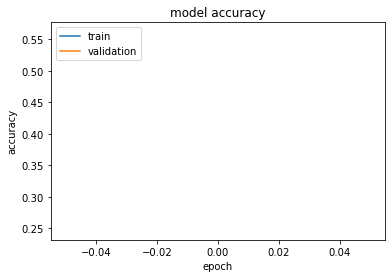

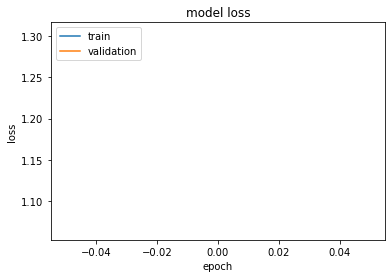

<Figure size 432x288 with 0 Axes>

In [22]:
graph_model_performance(history.history)

Evaluating Training data: 
18/18 [==============================] - 0s 25ms/step - loss: 1.2333 - binary_accuracy: 0.3025
{'loss': 1.2332707643508911, 'binary_accuracy': 0.30251345038414}
tf.Tensor(
[[509 594]
 [960 165]], shape=(2, 2), dtype=int32)
Generating 5 false positives and 5 false negatives...


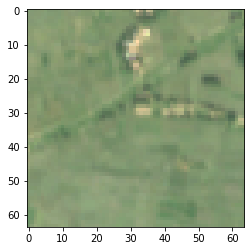

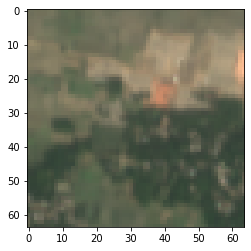

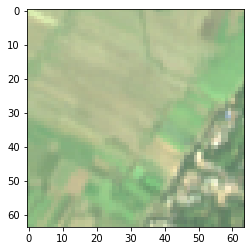

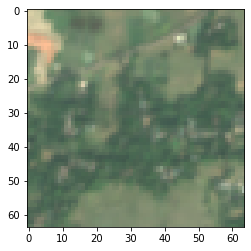

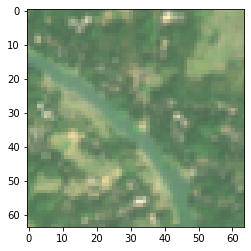

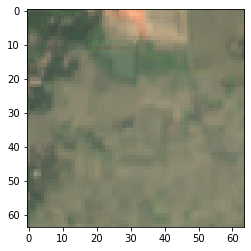

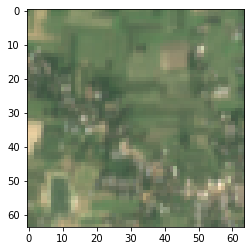

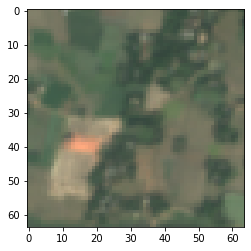

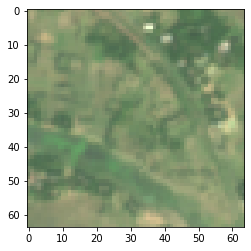

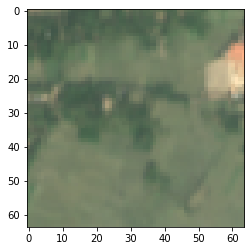

Evaluating Validation data: 
3/3 [==============================] - 0s 13ms/step - loss: 1.3044 - binary_accuracy: 0.2476
{'loss': 1.3044145107269287, 'binary_accuracy': 0.2476489096879959}
tf.Tensor(
[[ 57  87]
 [153  22]], shape=(2, 2), dtype=int32)
Generating 5 false positives and 5 false negatives...


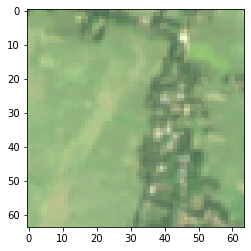

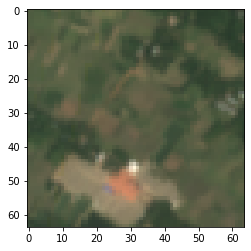

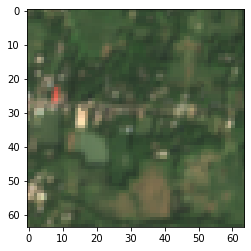

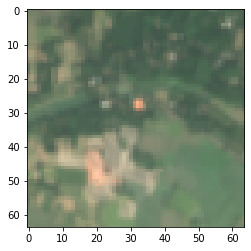

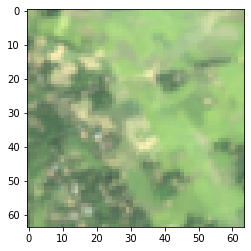

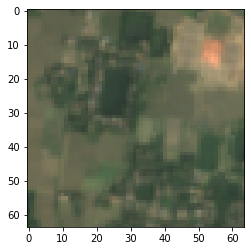

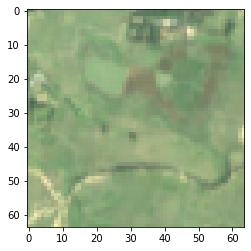

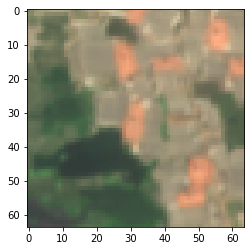

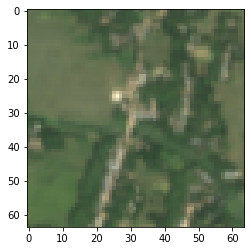

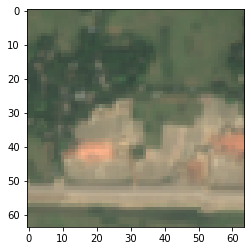

Evaluating Test data: 
5/5 [==============================] - 0s 19ms/step - loss: 1.1864 - binary_accuracy: 0.2951
{'loss': 1.1864440441131592, 'binary_accuracy': 0.29513344168663025}
tf.Tensor(
[[159 186]
 [263  29]], shape=(2, 2), dtype=int32)
Generating 5 false positives and 5 false negatives...


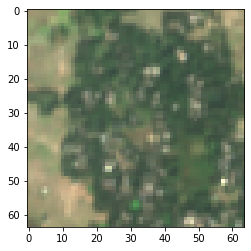

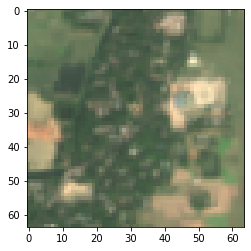

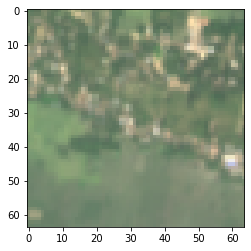

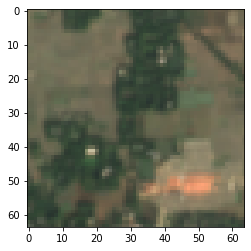

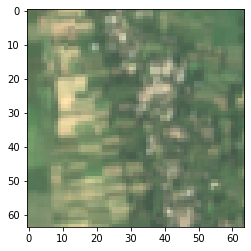

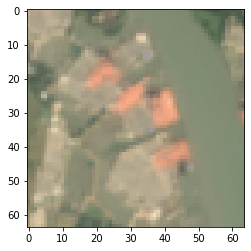

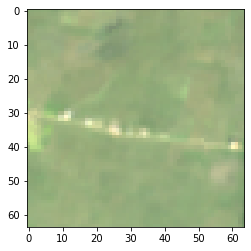

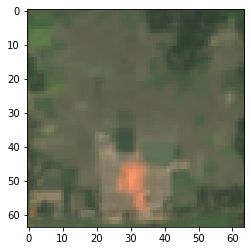

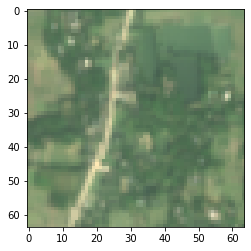

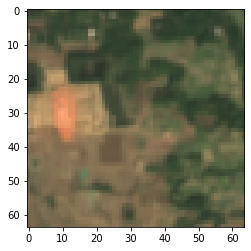

<Figure size 432x288 with 0 Axes>

In [29]:
evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test)

array([23.45573072, 89.21761975, 23.46147994, 89.22336896])